In [687]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

In [688]:
df_bilt = pd.read_csv('Data/de_bilt_weather.csv')

#shift days so that the first day starts from zero
df_bilt['days'] = df_bilt['days'] - df_bilt['days'].min()

variables = ['cloud_cover', 'wind_speed', 'wind_gust', 'humidity',
             'pressure', 'global_radiation', 'precipitation', 'sunshine', 
             'temp_mean', 'temp_min', 'temp_max'] 

n_var = len(variables) 

In [689]:
#Training on year of data, testing on 10 days
train_range = 365
test_range = 10

In [690]:
#Extracting data with shape (n_var, train_range+test_range)
data = []
for variable_name in variables:
    data.append(df_bilt[variable_name][:train_range + test_range])
data = np.vstack(data)

In [691]:
#Spliting training and test sets
train_data = data[:, :train_range]   
test_data = data[:, train_range:]

In [692]:
#Cost function for the optimizer
def var_initial_norm(params, data, means, n_var):
    c = params[:n_var]
    matrix = params[n_var:].reshape(n_var, n_var)
    prediction = c[:, None] + matrix @ data[:, :-1]
    residuals = data[:, 1:] - prediction
    return np.linalg.norm(residuals / means[:, None])

In [693]:
#Initialize c and M to zero
params = np.zeros(n_var + n_var**2)
means = np.mean(train_data, axis=1)

#Scipy's optimizer fits model parameters by minimizing cost function
result = scipy.optimize.minimize(var_initial_norm, params, method='Powell', args=(train_data, means, n_var))

#Represents the fitted intercepts and coefficient matrix
c_var = result.x[:n_var]
M_var = result.x[n_var:].reshape(n_var, n_var)

#Calculate residuals of fitted model
residuals = train_data[:, 1:] - (c_var[:, None] + M_var @ train_data[:, :-1])

#Generating uncertainty in predictions
std_var = np.std(residuals, axis=1)

In [694]:
#Produces predictions for next day given today, fits model plus normally distributed noise for uncertainty.
def weather_var(x, c, M, std):
    return c + M @ x + np.random.normal(0, std)

#Time indices for training and testing
t_train_data = np.arange(train_range)
t_test_data = np.arange(train_range, train_range + test_range)

#Number of simulation runs to capture uncertainty
prediction_list = []
n_predictions = 1000 

for j in range(n_predictions):
    #First test day is initial condition
    prediction = [test_data[:, 0]]
    #Predict forward for remaining test days
    for _ in t_test_data[1:]:
        prediction.append(weather_var(prediction[-1], c_var, M_var, std_var))
    prediction = np.array(prediction).T
    prediction_list.append(prediction)

#List of predictions converting to array with shape (n_predictions, n_var, test_range)
prediction_matrix = np.array(prediction_list)

In [695]:
import math

def norm_cdf(z):
    #cdf of the standard normal variable at point z using error function (erf).
    return 0.5 * (1 + math.erf(z / math.sqrt(2)))

def diebold_mariano_test(d):
    #Converting np array for vectorized operatoring
    d = np.array(d)
    
    #T is the number of observations of loss differentials in the data
    T = d.size
    d_bar = np.mean(d)
    lag = 1

    # Compute sample variance of d
    var_d = np.sum((d - d_bar)**2) / T

    #Dm stat:
    dm_stat = d_bar / np.sqrt(var_d / T)

    #two-sided test: p-value = 2 * (1 - cdf(|dm_stat|))
    p_value = 2 * (1 - norm_cdf(abs(dm_stat)))

    return dm_stat, p_value

In [696]:
#Training Sample sizes to test
sample_sizes = [50, 100, 150, 200, 250, 300, 350, 365] 
test_range = test_data.shape[1]  #Same test range

#Storing forecasts and errors for each sample size scenario
forecast_dict = {}
error_dict = {}

for size in sample_sizes:
    #Taking the first size of days from training data for this training set
    curr_train_data = data[:, :size]
    curr_means = np.mean(curr_train_data, axis=1)
    
    #Fit VAR model for this training size
    curr_params = np.zeros(n_var + n_var**2)
    curr_result = scipy.optimize.minimize(var_initial_norm, curr_params, method='Powell', args=(curr_train_data, curr_means, n_var))
    curr_c_var = curr_result.x[:n_var]
    curr_M_var = curr_result.x[n_var:].reshape(n_var, n_var)
    
    #Produce forecasts for the test period
    #Initializing form from first day of test set
    forecast = [test_data[:, 0]]
    for i in range(1, test_range):
        #No noise added for this forecast, just c + M*x_(t-1).
        next_day_forecast = curr_c_var + curr_M_var @ forecast[-1]
        forecast.append(next_day_forecast)
    forecast = np.array(forecast).T 
    
    #Store forecast
    forecast_dict[size] = forecast
    
    #Compute squared errors as the loss
    #Actual vs forecast over the same test period
    errors = (test_data - forecast)**2
    error_dict[size] = errors

# Choose the baseline scenario (e.g., largest training set)
baseline_size = max(sample_sizes)
baseline_errors = error_dict[baseline_size]

In [697]:
#Compare all other scenarios to the baseline
scenarios = [s for s in sample_sizes if s != baseline_size]
num_scenarios = len(scenarios)
num_vars = len(variables)


#Results matrix stores if current scenarios forecasts are significantly better, worse, or same compared to baseline
#1 = current scenario is significantly better than baseline
#0 = no significant difference
#-1 = current scenario is significantly worse than baseline

result_matrix = np.zeros((num_scenarios, num_vars))

#Stores the p-values from the DM tests for each scenario and variable
pval_matrix = np.ones((num_scenarios, num_vars))

scenario_num = 0
for size in sample_sizes:
    if size != baseline_size:
        # For each variable compare the forecast errors of this scenario with the baseline scenario
        for variable_num, var_name in enumerate(variables):
            baseline_err = baseline_errors[variable_num, :]
            current_err = error_dict[size][variable_num, :]

            #find loss differential between scenarios error and baselines
            d = current_err - baseline_err

            #DM test
            dm_stat, p_value = diebold_mariano_test(d)
            mean_baseline = np.mean(baseline_err)
            mean_current = np.mean(current_err)
            
            pval_matrix[scenario_num, variable_num] = p_value

            #If p-value >= 0.05, we cannot reject null hypothesis of no difference in predictive accuracy, so 0
            if p_value < 0.05:
                if mean_current < mean_baseline:
                    #Current scenario has significantly lower mean error, which is better
                    result_matrix[scenario_num, variable_num] = 1
                else:
                    #Current scenario has significantly higher mean error, which is worse
                    result_matrix[scenario_num, variable_num] = -1
            else:
                result_matrix[scenario_num, variable_num] = 0

        scenario_num += 1

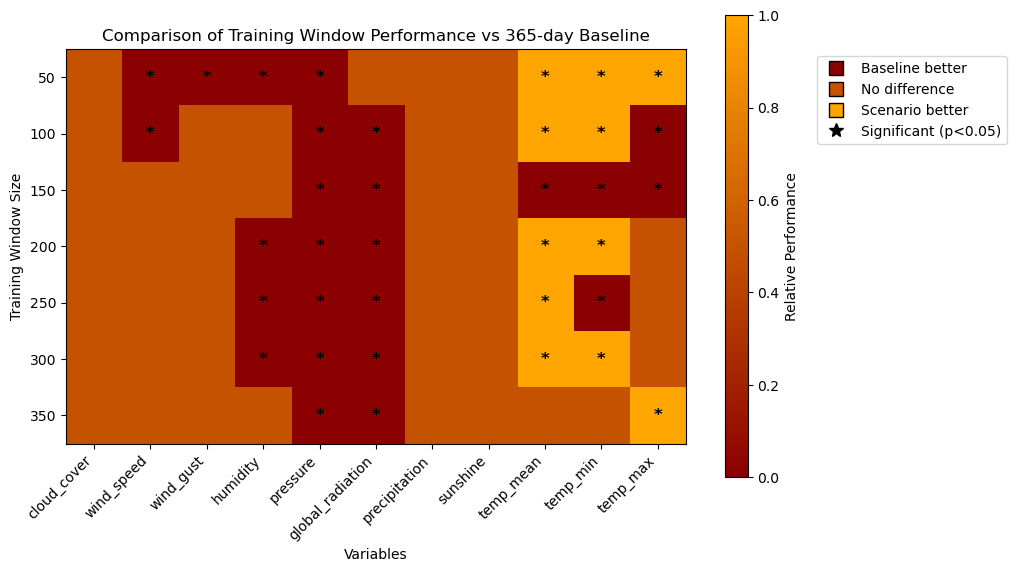

In [698]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D

#Mapping results to a 0-1 scale for colormaping
mapped_results = (result_matrix + 1) / 2.0

# darkred at value = 0.0, a blend around 0.5 for no difference, orange at mapped value = 1.0
cmap = LinearSegmentedColormap.from_list("custom_cmap", ["darkred", "orange"])

fig, ax = plt.subplots(figsize = (10, 6))
im = ax.imshow(mapped_results, cmap = cmap, vmin = 0.0, vmax = 1.0)

ax.set_yticks(np.arange(num_scenarios))
ax.set_yticklabels(scenarios)
ax.set_xticks(np.arange(num_vars))
ax.set_xticklabels(variables, rotation = 45, ha = 'right')
ax.set_xlabel("Variables")
ax.set_ylabel("Training Window Size")
ax.set_title(f"Comparison of Training Window Performance vs {baseline_size}-day Baseline")

#add stars where pval_matrix[i, j] < 0.05
for i in range(num_scenarios):
    for j in range(num_vars):
        if pval_matrix[i, j] < 0.05:
            ax.text(j, i, '*', ha = 'center', va = 'center', color = 'black', fontsize = 12, fontweight = 'bold')

cbar = fig.colorbar(im, ax = ax, ticks = np.arange(0.0, 1.1, 0.2))
cbar.set_label("Relative Performance")

#legend creation
baseline_lg = Line2D([], [], marker = 's', color = 'none', markerfacecolor = 'darkred', markersize = 10, label = 'Baseline better')
no_diff_lg = Line2D([], [], marker = 's', color = 'none', markerfacecolor = cmap(0.5), markersize = 10, label = 'No difference')
scenario_lg = Line2D([], [], marker = 's', color = 'none', markerfacecolor = 'orange', markersize = 10, label = 'Scenario better')
significance_lg = Line2D([], [], marker = '*', color = 'none', markerfacecolor = 'black', markersize = 10, label = 'Significant (p<0.05)')
ax.legend(handles=[baseline_lg, no_diff_lg, scenario_lg, significance_lg],
          loc='upper left', bbox_to_anchor=(1.2, 1))

plt.show()